<a href="https://colab.research.google.com/github/kostiantynvoskovtsov/masters-thesis/blob/main/td_denton_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries needed
import numpy as np
import pandas as pd
from IPython.display import display
# Filter and download quarterly GDP from Eurostat, then check whether data loaded correctly
def load_and_check(quarter_gdp):
    if quarter_gdp.shape[0] != 96: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return quarter_gdp
url = "https://drive.google.com/uc?id=1B1fCC3A-KgQ1pcxIrLWlASulJLhnKBiQ&export=download"
quarter_gdp = pd.read_csv(url)
display(load_and_check(quarter_gdp))

Data loaded properly.


,Quarter,Quarter GDP
0,2000-Q1,1473
1,2000-Q2,1516
2,2000-Q3,1541
3,2000-Q4,1640
4,2001-Q1,1660
...,...,...
91,2022-Q4,9214
92,2023-Q1,9395
93,2023-Q2,9397
94,2023-Q3,9404


In [ ]:
# Compute growth rates in log form, in order to observe changes over time and stabilise the variance
quarter_gdp['log Growth Rate'] = np.log(quarter_gdp['Quarter GDP'].astype(float))-np.log(quarter_gdp['Quarter GDP'].shift(1).astype(float))
quarter_gdp

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,NaN
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [ ]:
#impute missing values with median
quarter_gdp['log Growth Rate'] = quarter_gdp['log Growth Rate'].fillna(np.nanmedian(quarter_gdp['log Growth Rate']))
display(quarter_gdp)

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,0.023865
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [ ]:
import statsmodels.api as sm
# Fit AR model to see whether there are patterns/correlations within growth rates
log_gr = quarter_gdp['log Growth Rate']
model = sm.tsa.arima.ARIMA(log_gr, order=(1,0,0))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:        log Growth Rate   No. Observations:                   96
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 213.210
Date:                Wed, 15 May 2024   AIC                           -420.420
Time:                        15:04:48   BIC                           -412.727
Sample:                             0   HQIC                          -417.310
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.004      4.612      0.000       0.011       0.028
ar.L1          0.2630      0.064      4.082      0.000       0.137       0.389
sigma2         0.0007   7.98e-05      8.628      0.0

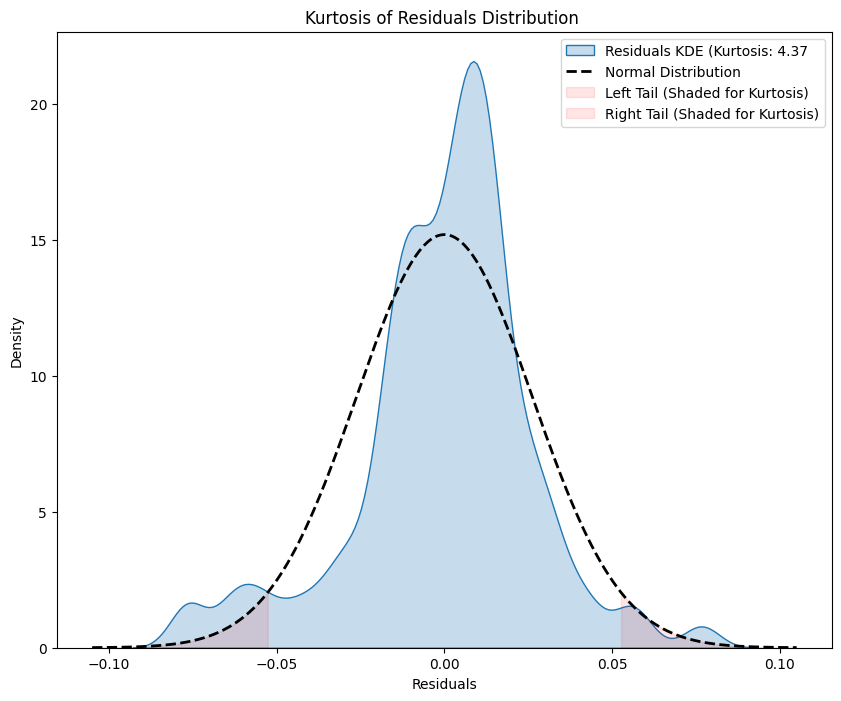

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis
mu = np.mean(fitted_model.resid)
sig = np.std(fitted_model.resid)
# Generating points for a normal distribution curve
x = np.linspace(mu - 4*sig, mu + 4*sig, 1000)
y = norm.pdf(x, mu, sig)
# Create the plot
plt.figure(figsize=(10, 8))
sns.kdeplot(fitted_model.resid, bw_adjust=0.5, fill=True, label='Residuals KDE (Kurtosis: 4.37')
plt.plot(x, y, 'k--', linewidth=2, label='Normal Distribution')
# Horizontal line for normal distribution peak (kurtosis = 3)
normal_peak_y = norm.pdf(mu, mu, sig)
#plt.axhline(y=normal_peak_y, color='orange', linestyle='-', linewidth=2, label='Kurtosis: 3')
# Shade the tails to show the kurtosis visually
tail_shade = 0.1  # Adjust the transparency for tail shading
plt.fill_between(x, y, where=(x < mu - 2*sig), color='red', alpha=tail_shade, label='Left Tail (Shaded for Kurtosis)')
plt.fill_between(x, y, where=(x > mu + 2*sig), color='red', alpha=tail_shade, label='Right Tail (Shaded for Kurtosis)')
# Plot customization
plt.title('Kurtosis of Residuals Distribution ')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Check fat tails in the original log growth rates
from scipy.stats import kurtosis
# Calculate kurtosis
log_gr_resid_kurt = kurtosis(quarter_gdp['log Growth Rate'], fisher=False)
print("Kurtosis:", log_gr_resid_kurt)

Kurtosis: 5.062198908065938


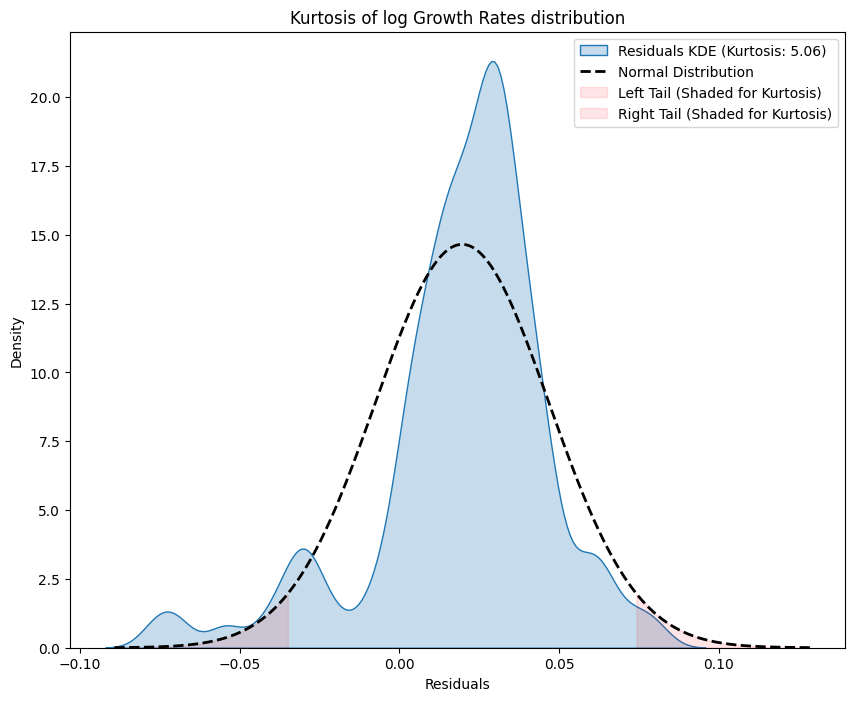

In [ ]:
mu = np.mean(quarter_gdp['log Growth Rate'])
sig = np.std(quarter_gdp['log Growth Rate'])
# Generating points for a normal distribution curve
x = np.linspace(mu - 4*sig, mu + 4*sig, 1000)
y = norm.pdf(x, mu, sig)
# Create the plot
plt.figure(figsize=(10, 8))
sns.kdeplot(quarter_gdp['log Growth Rate'], bw_adjust=0.5, fill=True, label=f'Residuals KDE (Kurtosis: {log_gr_resid_kurt:.2f})')
plt.plot(x, y, 'k--', linewidth=2, label='Normal Distribution')
# Horizontal line for normal distribution peak (kurtosis = 3)
normal_peak_y = norm.pdf(mu, mu, sig)
#plt.axhline(y=normal_peak_y, color='orange', linestyle='-', linewidth=2, label='Kurtosis: 3')
# Shade the tails to show the kurtosis visually
tail_shade = 0.1  # Adjust the transparency for tail shading
plt.fill_between(x, y, where=(x < mu - 2*sig), color='red', alpha=tail_shade, label='Left Tail (Shaded for Kurtosis)')
plt.fill_between(x, y, where=(x > mu + 2*sig), color='red', alpha=tail_shade, label='Right Tail (Shaded for Kurtosis)')
# Plot customization
plt.title('Kurtosis of log Growth Rates distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.random.seed(24)  # Set a random seed for reproducibility
# Assuming fitted_model.resid, log_gr are previously defined
mu = 0
sig = np.std(fitted_model.resid)
# Initialize an array to store the generated residuals (for Monte Carlo simulation)
generated_residuals = np.zeros((len(log_gr), 1000))  # Using np.zeros for clarity and initialization to zero
# Generate 1000 sets of residuals (for Monte Carlo simulation)
for i in range(1000):
    # Generate new residuals (using normal distribution) and append the new residuals to the generated_residuals array #, size=len(log_gr)
    generated_residuals[:, i] = np.random.normal(loc = mu,scale=sig, size=len(log_gr))
# Print the mean and standard deviation of the residuals

print("Standard deviation of residuals:", sig)
# Display the generated residuals
residuals_df = pd.DataFrame(generated_residuals)
display(residuals_df)

Standard deviation of residuals: 0.02624602594821196


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.034887,0.026227,0.028616,-0.022123,-0.009619,0.045882,-0.001171,-0.038796,0.024780,0.057445,...,-0.006880,-0.012700,0.060416,0.023818,0.032524,-0.026676,-0.012523,-0.030410,-0.002748,-0.004189
1,-0.020210,0.022895,0.037460,-0.035815,-0.021525,-0.033221,0.002513,-0.021025,-0.018050,-0.021210,...,-0.019185,-0.030337,0.016671,-0.022908,0.033615,0.039978,-0.016497,-0.018087,0.013796,0.002913
2,-0.008301,-0.049027,0.018188,0.012609,0.041019,-0.012393,0.014023,0.033117,-0.039757,0.018448,...,-0.019184,-0.003507,-0.043790,0.018946,-0.022290,-0.013446,-0.003189,-0.039047,0.033428,0.011212
3,-0.026005,0.032302,0.004861,0.005201,-0.002684,0.003839,0.033898,-0.005817,-0.010327,0.052860,...,0.011328,-0.025179,0.008759,0.008516,0.007979,-0.019936,0.000836,0.009281,0.043921,0.023108
4,-0.028105,-0.003373,0.002820,0.003477,-0.012891,0.001300,-0.025296,0.029573,0.026195,-0.050654,...,-0.012879,0.015041,0.042621,0.026354,-0.014402,0.054891,0.016249,0.004593,0.035589,-0.020734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.022863,0.009231,-0.073648,-0.006901,0.012620,0.010527,-0.003743,-0.004642,-0.006902,0.006944,...,0.044258,0.056851,0.009613,-0.031276,-0.075017,-0.017307,-0.000494,-0.000447,0.023090,-0.034420
92,-0.025467,0.006968,-0.023871,0.004557,0.027096,0.023757,0.020351,-0.032848,0.025024,-0.025608,...,0.012142,-0.009735,-0.018434,0.016683,-0.035988,0.033849,-0.033597,-0.033158,0.004518,0.039109
93,0.011112,0.002775,0.058695,0.014739,0.007565,-0.029886,0.022527,0.034570,0.021725,0.019520,...,0.034852,0.027666,-0.031139,-0.017255,0.018497,0.009034,0.009649,-0.018272,0.030678,-0.015797
94,0.051816,-0.015162,-0.015135,0.026401,-0.011102,-0.059634,0.032226,-0.022876,-0.031320,-0.017459,...,0.038641,0.014499,0.007247,-0.024953,0.020560,-0.021026,0.022391,-0.020073,-0.015979,0.024652


In [ ]:
# Parameters from the fitted AR model
const = fitted_model.params['const']
AR = fitted_model.arparams[0]
print('Const:',const)
print('AR:',AR)
# Initialize arrays to store simulated GDP and log growth rates
sim_q_gdp = np.zeros([len(log_gr), 1000])
sim_log_gr = np.zeros([len(log_gr), 1000])
# Perform Monte Carlo simulation
for i in range(1000):
    for t in range(1, len(log_gr)):
        sim_log_gr[t, i] = const + AR * sim_log_gr[t-1, i] + generated_residuals[t, i]
        sim_q_gdp[:, i] = quarter_gdp['Quarter GDP'].iloc[0] * (np.exp(np.cumsum(sim_log_gr[:, i]))) #THIS LINE IS THE KEY
#Assign simulated data to a variable, so it can be reused
sim_q_gdp_df = pd.DataFrame(sim_q_gdp)
# Display the simulated GDP DataFrame
print('Simulated GDP DataFrame:')
display(sim_q_gdp_df)
# Display first value from original dataframe
print('First value from original dataframe:')
display(quarter_gdp['Quarter GDP'].iloc[0])

Const: 0.019621402364078014
AR: 0.262959379954952
Simulated GDP DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
1,1472.132783,1536.977608,1559.527273,1449.339198,1470.198839,1453.104041,1505.967736,1470.934346,1475.316925,1470.661389,...,1473.642415,1457.300778,1527.440836,1468.167047,1553.542159,1563.458478,1477.609341,1475.261311,1523.056049,1506.570150
2,1488.661897,1509.219182,1644.115066,1490.452248,1561.328657,1458.420901,1566.589108,1550.018948,1446.504715,1527.089498,...,1474.456181,1476.807088,1505.263667,1524.578440,1571.245243,1597.991830,1503.325917,1447.463848,1620.209240,1562.980879
3,1483.538756,1582.053051,1708.428355,1539.192229,1613.311698,1494.474724,1669.957333,1593.356525,1452.458752,1658.222370,...,1521.024591,1473.765622,1542.651274,1583.709982,1620.036742,1606.693509,1541.375165,1482.475265,1754.806010,1647.058150
4,1469.673837,1628.021278,1764.919472,1588.543867,1638.255754,1535.901316,1688.643347,1685.881057,1522.195999,1642.759153,...,1543.886921,1524.918443,1652.345897,1674.896934,1641.663423,1733.458795,1608.203768,1528.385584,1893.739126,1668.052164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,20329.456405,19491.793525,10966.034138,9908.798497,10579.611734,24706.902539,19062.371913,19484.732330,14858.919450,34969.940633,...,10802.052292,22804.889513,15076.581978,35635.141228,21366.659695,16845.849146,33990.360131,17447.975169,14547.930887,38657.509802
92,20451.261645,20111.179028,10813.088094,10229.891912,11181.934758,25989.326348,19993.341989,19305.898910,15613.300312,35145.801562,...,11359.083082,23595.094535,15237.819187,36927.227299,20720.565359,17791.805700,33771.018077,17392.362543,15109.224714,40958.463847
93,21122.700532,20736.547699,11650.867884,10676.662376,11658.623136,26068.513289,21117.169809,20331.618121,16485.682029,36596.961542,...,12154.670036,24960.218226,15105.522101,37363.002056,21352.541407,18573.948803,34714.955920,17401.236283,16047.604697,41745.292564
94,22880.393471,20997.621489,11935.175454,11305.883661,11888.156879,25066.085036,22563.077634,20543.295613,16528.576875,37068.491700,...,13115.263342,26211.386601,15481.350545,37279.155377,22404.296150,18758.895639,36467.882414,17395.715881,16363.390811,43853.887116


First value from original dataframe:


1473

In [ ]:
# Create a DatetimeIndex for the DataFrame
index = pd.date_range(start='2000-01-01', periods=len(log_gr), freq='Q')
# Add index
sim_q_gdp_df.index = index
# Display quarterly simulated gdp values
display(sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
2000-06-30,1472.132783,1536.977608,1559.527273,1449.339198,1470.198839,1453.104041,1505.967736,1470.934346,1475.316925,1470.661389,...,1473.642415,1457.300778,1527.440836,1468.167047,1553.542159,1563.458478,1477.609341,1475.261311,1523.056049,1506.570150
2000-09-30,1488.661897,1509.219182,1644.115066,1490.452248,1561.328657,1458.420901,1566.589108,1550.018948,1446.504715,1527.089498,...,1474.456181,1476.807088,1505.263667,1524.578440,1571.245243,1597.991830,1503.325917,1447.463848,1620.209240,1562.980879
2000-12-31,1483.538756,1582.053051,1708.428355,1539.192229,1613.311698,1494.474724,1669.957333,1593.356525,1452.458752,1658.222370,...,1521.024591,1473.765622,1542.651274,1583.709982,1620.036742,1606.693509,1541.375165,1482.475265,1754.806010,1647.058150
2001-03-31,1469.673837,1628.021278,1764.919472,1588.543867,1638.255754,1535.901316,1688.643347,1685.881057,1522.195999,1642.759153,...,1543.886921,1524.918443,1652.345897,1674.896934,1641.663423,1733.458795,1608.203768,1528.385584,1893.739126,1668.052164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,20329.456405,19491.793525,10966.034138,9908.798497,10579.611734,24706.902539,19062.371913,19484.732330,14858.919450,34969.940633,...,10802.052292,22804.889513,15076.581978,35635.141228,21366.659695,16845.849146,33990.360131,17447.975169,14547.930887,38657.509802
2023-03-31,20451.261645,20111.179028,10813.088094,10229.891912,11181.934758,25989.326348,19993.341989,19305.898910,15613.300312,35145.801562,...,11359.083082,23595.094535,15237.819187,36927.227299,20720.565359,17791.805700,33771.018077,17392.362543,15109.224714,40958.463847
2023-06-30,21122.700532,20736.547699,11650.867884,10676.662376,11658.623136,26068.513289,21117.169809,20331.618121,16485.682029,36596.961542,...,12154.670036,24960.218226,15105.522101,37363.002056,21352.541407,18573.948803,34714.955920,17401.236283,16047.604697,41745.292564
2023-09-30,22880.393471,20997.621489,11935.175454,11305.883661,11888.156879,25066.085036,22563.077634,20543.295613,16528.576875,37068.491700,...,13115.263342,26211.386601,15481.350545,37279.155377,22404.296150,18758.895639,36467.882414,17395.715881,16363.390811,43853.887116


In [ ]:
#Load original annual GDP from Eurostat
def load_and_check(annual_gdp):
    if annual_gdp.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_gdp
url = "https://drive.google.com/uc?id=1CFulC9DNeJ1O44xW-cKUeYDwlfn6aIPG&export=download"
annual_gdp = pd.read_csv(url)
display(load_and_check(annual_gdp))

Data loaded properly.


,Year,Annual GDP
0,2000,6172
1,2001,6987
2,2002,7823
3,2003,8744
4,2004,9778
5,2005,11343
6,2006,13569
7,2007,16401
8,2008,16618
9,2009,14132


In [ ]:
# Ensure the index for annual_gdp is set to the Year column and is of datetime type
annual_gdp.set_index(pd.to_datetime(annual_gdp['Year'], format='%Y'), inplace=True)
# Prepare an empty DataFrame with the correct shape: 96 quarters x 1000 simulations
normalized_sim_q_gdp_df = pd.DataFrame(index=sim_q_gdp_df.index, columns=range(sim_q_gdp_df.shape[1]))
# Normalize quarterly simulated values
for i in range(normalized_sim_q_gdp_df.shape[1]):  # iterating over each simulation
    sim_data = sim_q_gdp_df.iloc[:, i]  # get the simulation column
    sim_data_yearly = sim_data.resample('A-DEC').sum()  # sum quarterly data to annual
    for year in sim_data_yearly.index.year:
        if year in annual_gdp.index.year:
            yearly_total = sim_data_yearly[sim_data_yearly.index.year == year].iloc[0]
            annual_gdp_value = annual_gdp.loc[pd.Timestamp(year=year, month=1, day=1)]['Annual GDP']
            # Normalize quarterly values
            quarter_mask = (sim_data.index.year == year)
            normalized_quarters = (sim_data[quarter_mask] / yearly_total) * annual_gdp_value
            # Assign normalized values to the corresponding year and simulation column
            normalized_sim_q_gdp_df.loc[normalized_quarters.index, i] = normalized_quarters.values
# Convert all columns to float
normalized_sim_q_gdp_df = normalized_sim_q_gdp_df.astype(float)
# Ensure the index is sorted and set as a datetime index
normalized_sim_q_gdp_df.sort_index(inplace=True)
display(normalized_sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1536.394070,1490.080924,1423.845786,1527.449754,1486.040367,1546.412063,1462.687678,1493.493229,1554.800760,1483.340785,...,1529.984437,1545.919330,1503.111975,1502.838734,1462.144279,1456.681062,1516.411221,1546.622324,1426.974456,1468.809377
2000-06-30,1535.489530,1554.800417,1507.485632,1502.914325,1483.214408,1525.524519,1495.424610,1491.398837,1557.246353,1480.985756,...,1530.651705,1529.442934,1558.665724,1497.907880,1542.092858,1546.137377,1521.156406,1548.996658,1475.466447,1502.284021
2000-09-30,1552.730014,1526.720104,1589.250718,1545.547128,1575.150991,1531.106364,1555.621579,1571.583710,1526.834101,1537.810003,...,1531.496952,1549.914883,1536.035196,1555.462005,1559.665474,1580.288143,1547.630882,1519.809844,1569.583978,1558.534264
2000-12-31,1547.386386,1600.398555,1651.417864,1596.088792,1627.594234,1568.957054,1658.266133,1615.524224,1533.118786,1669.863457,...,1579.866906,1546.722853,1574.187104,1615.791381,1608.097389,1588.893419,1586.801491,1556.571174,1699.975119,1642.372339
2001-03-31,1732.705126,1609.964775,1709.305263,1608.260061,1640.686507,1638.931862,1741.378561,1619.359973,1702.051553,1721.672757,...,1688.114205,1685.114741,1711.302657,1582.804253,1715.375681,1620.549716,1664.662385,1657.452548,1680.618220,1681.965151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,9395.896072,9051.747653,9103.067816,9518.919146,9195.745455,9202.910740,9517.708861,9163.354399,9307.407637,9653.203408,...,9611.701986,10037.462177,9490.771693,9158.440323,8672.577263,9129.378374,9445.927187,9694.370750,9596.440638,9272.006934
2023-03-31,8710.190693,9119.242733,8678.012550,8830.758109,8918.496872,9541.596360,8713.949170,9031.301128,8915.317311,9100.826606,...,8386.661515,8633.410802,9215.084218,9389.951377,8859.768273,8984.296438,8908.642877,9327.306380,8867.553765,8961.232596
2023-06-30,8996.156461,9402.810827,9350.370295,9216.424148,9298.694387,9570.668673,9203.761153,9511.132661,9413.454135,9476.597104,...,8974.060905,9132.907577,9135.077442,9500.761316,9129.990695,9379.253848,9157.649440,9332.065256,9418.285858,9133.381512
2023-09-30,9744.757743,9521.192513,9578.540512,9759.587362,9481.766101,9202.641982,9833.949308,9610.155409,9437.947429,9598.697440,...,9683.288125,9590.708267,9362.360016,9479.440564,9579.703487,9472.646122,9620.063575,9329.104733,9603.619679,9594.717325


In [ ]:
# Verification by Resampling Annually and Comparing with Actual Annual GDP
resampled_annual_values = normalized_sim_q_gdp_df.resample('A-DEC').sum()

# Create the comparison DataFrame if resampling produced a non-empty DataFrame
if not resampled_annual_values.empty:
    common_years = set(resampled_annual_values.index.year).intersection(set(annual_gdp.index.year))
    resampled_annual_values = resampled_annual_values[resampled_annual_values.index.year.isin(common_years)]
    annual_gdp_filtered = annual_gdp[annual_gdp.index.year.isin(common_years)]

    # Convert common_years set to a sorted list for DataFrame index
    common_years_list = sorted(list(common_years))

    comparison_df = pd.DataFrame({
        'Simulated Normalised Annual GDP': resampled_annual_values.iloc[:, 0].values,
        'Actual Annual GDP': annual_gdp_filtered['Annual GDP'].values
    }, index=common_years_list)

    print(comparison_df)
else:
    print("resampled_annual_values is empty after resampling. Check resample method.")


      Simulated Normalised Annual GDP  Actual Annual GDP
2000                           6172.0               6172
2001                           6987.0               6987
2002                           7823.0               7823
2003                           8744.0               8744
2004                           9778.0               9778
2005                          11343.0              11343
2006                          13569.0              13569
2007                          16401.0              16401
2008                          16618.0              16618
2009                          14132.0              14132
2010                          14741.0              14741
2011                          16677.0              16677
2012                          17917.0              17917
2013                          18911.0              18911
2014                          20048.0              20048
2015                          20631.0              20631
2016                          2

In [ ]:
display(normalized_sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1536.394070,1490.080924,1423.845786,1527.449754,1486.040367,1546.412063,1462.687678,1493.493229,1554.800760,1483.340785,...,1529.984437,1545.919330,1503.111975,1502.838734,1462.144279,1456.681062,1516.411221,1546.622324,1426.974456,1468.809377
2000-06-30,1535.489530,1554.800417,1507.485632,1502.914325,1483.214408,1525.524519,1495.424610,1491.398837,1557.246353,1480.985756,...,1530.651705,1529.442934,1558.665724,1497.907880,1542.092858,1546.137377,1521.156406,1548.996658,1475.466447,1502.284021
2000-09-30,1552.730014,1526.720104,1589.250718,1545.547128,1575.150991,1531.106364,1555.621579,1571.583710,1526.834101,1537.810003,...,1531.496952,1549.914883,1536.035196,1555.462005,1559.665474,1580.288143,1547.630882,1519.809844,1569.583978,1558.534264
2000-12-31,1547.386386,1600.398555,1651.417864,1596.088792,1627.594234,1568.957054,1658.266133,1615.524224,1533.118786,1669.863457,...,1579.866906,1546.722853,1574.187104,1615.791381,1608.097389,1588.893419,1586.801491,1556.571174,1699.975119,1642.372339
2001-03-31,1732.705126,1609.964775,1709.305263,1608.260061,1640.686507,1638.931862,1741.378561,1619.359973,1702.051553,1721.672757,...,1688.114205,1685.114741,1711.302657,1582.804253,1715.375681,1620.549716,1664.662385,1657.452548,1680.618220,1681.965151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,9395.896072,9051.747653,9103.067816,9518.919146,9195.745455,9202.910740,9517.708861,9163.354399,9307.407637,9653.203408,...,9611.701986,10037.462177,9490.771693,9158.440323,8672.577263,9129.378374,9445.927187,9694.370750,9596.440638,9272.006934
2023-03-31,8710.190693,9119.242733,8678.012550,8830.758109,8918.496872,9541.596360,8713.949170,9031.301128,8915.317311,9100.826606,...,8386.661515,8633.410802,9215.084218,9389.951377,8859.768273,8984.296438,8908.642877,9327.306380,8867.553765,8961.232596
2023-06-30,8996.156461,9402.810827,9350.370295,9216.424148,9298.694387,9570.668673,9203.761153,9511.132661,9413.454135,9476.597104,...,8974.060905,9132.907577,9135.077442,9500.761316,9129.990695,9379.253848,9157.649440,9332.065256,9418.285858,9133.381512
2023-09-30,9744.757743,9521.192513,9578.540512,9759.587362,9481.766101,9202.641982,9833.949308,9610.155409,9437.947429,9598.697440,...,9683.288125,9590.708267,9362.360016,9479.440564,9579.703487,9472.646122,9620.063575,9329.104733,9603.619679,9594.717325


In [ ]:
#Load original annual consumption aggregates from Eurostat
def load_and_check(annual_cons):
    if annual_cons.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_cons
url = "https://drive.google.com/uc?id=1NY4nmAB4zZ3WTAdXTrDSLCyAu0vTJWIA&export=download"
annual_cons = pd.read_csv(url)
display(load_and_check(annual_cons))

Data loaded properly.


,Year,Annual cons agg
0,2000,3636
1,2001,4113
2,2002,4588
3,2003,5043
4,2004,5709
5,2005,6486
6,2006,7591
7,2007,8742
8,2008,8997
9,2009,7753


In [ ]:
# Convert the first column to datetime and set as the index
annual_cons.index = pd.to_datetime(annual_cons.iloc[:, 0], format='%Y')
annual_cons.drop(annual_cons.columns[0], axis=1, inplace=True)  # Drop the redundant column if needed
display(annual_cons)

,Annual cons agg
Year,
2000-01-01,3636
2001-01-01,4113
2002-01-01,4588
2003-01-01,5043
2004-01-01,5709
2005-01-01,6486
2006-01-01,7591
2007-01-01,8742
2008-01-01,8997


In [ ]:
from statsmodels.tsa.interp.denton import dentonm
# Prepare the DataFrame to store the disaggregated results
disagg_data = pd.DataFrame(index=normalized_sim_q_gdp_df.index, columns=np.arange(1000))

# Disaggregate using the Denton method
for i in range(1000):
    # Benchmark series (quarterly data) for the current simulation
    benchmark = normalized_sim_q_gdp_df.iloc[:, i].values
    # Apply the Denton method
    disagg_series = dentonm(benchmark, annual_cons, freq='aq')
    disagg_data.iloc[:, i] = disagg_series

# 'disagg_data' now contains the disaggregated quarterly data for each simulation
display(disagg_data)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,905.337938,878.043827,839.02046,900.065197,875.665632,911.237974,861.903703,880.058126,916.181387,874.079243,...,901.559214,910.949257,885.729543,885.559037,861.581002,858.358672,893.55783,911.364063,840.868271,865.507925
2000-06-30,904.713519,916.092095,888.221805,885.519787,873.915555,898.840007,881.110534,878.737892,917.529882,872.60567,...,901.862668,901.149474,918.373091,882.568945,908.605562,910.986625,896.266759,912.670969,869.358898,885.14976
2000-09-30,914.68683,899.369959,936.214854,910.460261,927.904892,901.949826,916.402669,925.801819,899.429262,905.90873,...,902.181069,913.02833,904.853864,916.304592,918.78105,930.929736,911.687813,895.293,924.631918,918.117596
2000-12-31,911.261713,942.494119,972.542882,939.954755,958.513921,923.972192,976.583093,951.402163,902.85947,983.406356,...,930.397048,910.87294,927.043502,951.567425,947.032385,935.724968,934.487597,916.671968,1001.140914,967.224719
2001-03-31,1019.98225,947.74912,1006.217906,946.743509,965.834329,964.795971,1025.118039,953.27479,1001.942872,1013.502374,...,993.745544,991.972801,1007.375298,931.773824,1009.807179,953.991476,979.952429,975.687793,989.327114,990.149456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,4805.0135,4630.503687,4654.937862,4867.541867,4704.098311,4707.760257,4866.349722,4686.714683,4759.812685,4935.800529,...,4914.100311,5131.011918,4852.817434,4684.98006,4436.399156,4669.099668,4829.737504,4957.572323,4907.128149,4741.551764
2023-03-31,4488.394558,4700.778035,4471.836867,4550.700231,4596.880553,4919.184479,4490.089179,4655.00572,4594.667549,4690.27092,...,4320.646938,4447.903505,4749.032502,4840.765572,4566.38789,4630.460338,4590.655656,4807.493289,4569.80664,4618.153551
2023-06-30,4662.790515,4874.889743,4846.716205,4777.453266,4820.390768,4962.763826,4770.650326,4931.016464,4879.901653,4913.080336,...,4650.602604,4733.477373,4735.644095,4926.269672,4732.644773,4862.292254,4746.939398,4838.27824,4882.366703,4734.468334
2023-09-30,5070.990077,4955.241777,4984.70724,5079.194802,4934.300751,4790.069298,5117.837998,5001.72057,4911.829622,4996.117965,...,5038.606272,4991.078146,4872.846748,4934.021108,4985.102226,4929.929667,5006.666095,4855.744792,4998.172974,4993.383341


In [ ]:
#Load original quarterly consumption aggregats from Eurostat
def load_and_check(quarterly_cons):
    if quarterly_cons.shape[0] != 96: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return quarterly_cons
url = "https://drive.google.com/uc?id=1SxgMVn8YCA9tGB3e6fzTt8tT5TetY4xL&export=download"
quarterly_cons = pd.read_csv(url)
display(load_and_check(quarterly_cons))

Data loaded properly.


,Quarter,Quarter cons agg
0,2000-Q1,871
1,2000-Q2,903
2,2000-Q3,911
3,2000-Q4,949
4,2001-Q1,986
...,...,...
91,2022-Q4,4747
92,2023-Q1,4832
93,2023-Q2,4863
94,2023-Q3,4877


In [ ]:
# Convert the first column to datetime and set as the index
index = pd.date_range(start='2000-01-01', periods=len(quarterly_cons), freq='Q')  # Drop the redundant column if needed
quarterly_cons.index = index
quarterly_cons.drop(quarterly_cons.columns[0], axis=1, inplace=True)
display(quarterly_cons)

,Quarter cons agg
2000-03-31,871
2000-06-30,903
2000-09-30,911
2000-12-31,949
2001-03-31,986
...,...
2022-12-31,4747
2023-03-31,4832
2023-06-30,4863
2023-09-30,4877


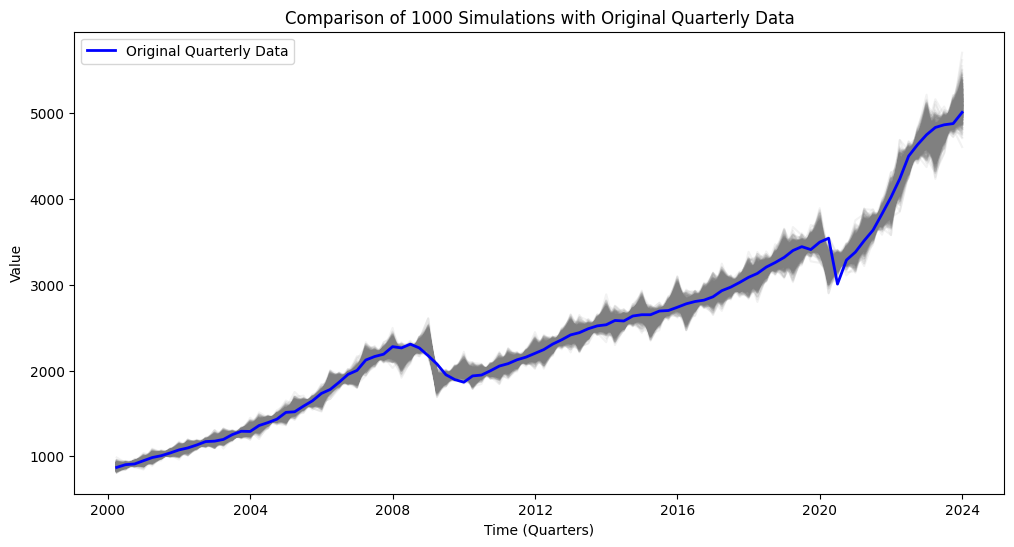

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming disagg_data is a NumPy array with shape (96, 1000)
# Assuming quarterly_cons is a DataFrame with a proper DateTime index or a 'Year' column

# Plotting
plt.figure(figsize=(12, 6))

# Plot each simulation scenario
for i in range(disagg_data.shape[1]):  # disagg_data.shape[1] is 1000, representing the number of columns
    plt.plot(quarterly_cons.index, disagg_data.iloc[:, i], color='grey', alpha=0.1)  # alpha controls the transparency

# Plot the original quarterly data
plt.plot(quarterly_cons.index, quarterly_cons['Quarter cons agg'], label='Original Quarterly Data', color='blue', linewidth=2)

# Add plot title and labels
plt.title('Comparison of 1000 Simulations with Original Quarterly Data')
plt.xlabel('Time (Quarters)')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show plot
plt.show()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure that the lengths of both datasets are the same
if len(disagg_data) != len(quarterly_cons):
    raise ValueError("The lengths of disaggregated data and true GDP data do not match.")

# Initialize arrays to store the metrics for each column and simulation
num_simulations = 1000
mae_values = np.zeros((num_simulations,))
rmse_values = np.zeros((num_simulations,))
mape_values = np.zeros((num_simulations,))
smape_values = np.zeros((num_simulations,))

true_gdp_values = quarterly_cons['Quarter cons agg'].values

# Calculate the metrics for each column of disaggregated data for each simulation
for i in range(num_simulations):
    disagg_column = disagg_data.iloc[:, i]

    # Calculate MAE
    mae_values[i] = mean_absolute_error(true_gdp_values, disagg_column)

    # Calculate RMSE
    rmse_values[i] = np.sqrt(mean_squared_error(true_gdp_values, disagg_column))

    # Calculate MAPE and sMAPE (avoiding division by zero)
    eps = 1e-10  # Small constant to avoid division by zero
    mape_values[i] = np.mean(np.abs((true_gdp_values - disagg_column) / (true_gdp_values + eps)))
    smape_values[i] = np.mean(np.abs(true_gdp_values - disagg_column) / (np.abs(true_gdp_values) + np.abs(disagg_column) + eps))

# Compute the mean of all simulations' error metrics
mean_mae = np.mean(mae_values)
mean_rmse = np.mean(rmse_values)
mean_mape = np.mean(mape_values)
mean_smape = np.mean(smape_values)

# Print the mean error metrics
print("Mean MAE across all simulations:", mean_mae)
print("Mean RMSE across all simulations:", mean_rmse)
print("Mean MAPE across all simulations:", mean_mape)
print("Mean sMAPE across all simulations:", mean_smape)

Mean MAE across all simulations: 63.930054226765584
Mean RMSE across all simulations: 93.52065230427424
Mean MAPE across all simulations: 0.025847884538540807
Mean sMAPE across all simulations: 0.012931007760177454
